In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

### unique values in all the features

In [8]:
for i in train.columns:
    print(i)
    print(train[i].unique())

PassengerId
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
HomePlanet
['Europa' 'Earth' 'Mars' nan]
CryoSleep
[False True nan]
Cabin
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Age
[39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]
VIP
[False True nan]
RoomService
[   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt
[   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall
[   0.   25.  371. ... 1085.  510. 1872.]
Spa
[   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck
[   0.   44.   49. ... 1164.  971. 3235.]
Name
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']

In [9]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

## Distribution plots for numerical variables

<Axes: xlabel='FoodCourt', ylabel='Count'>

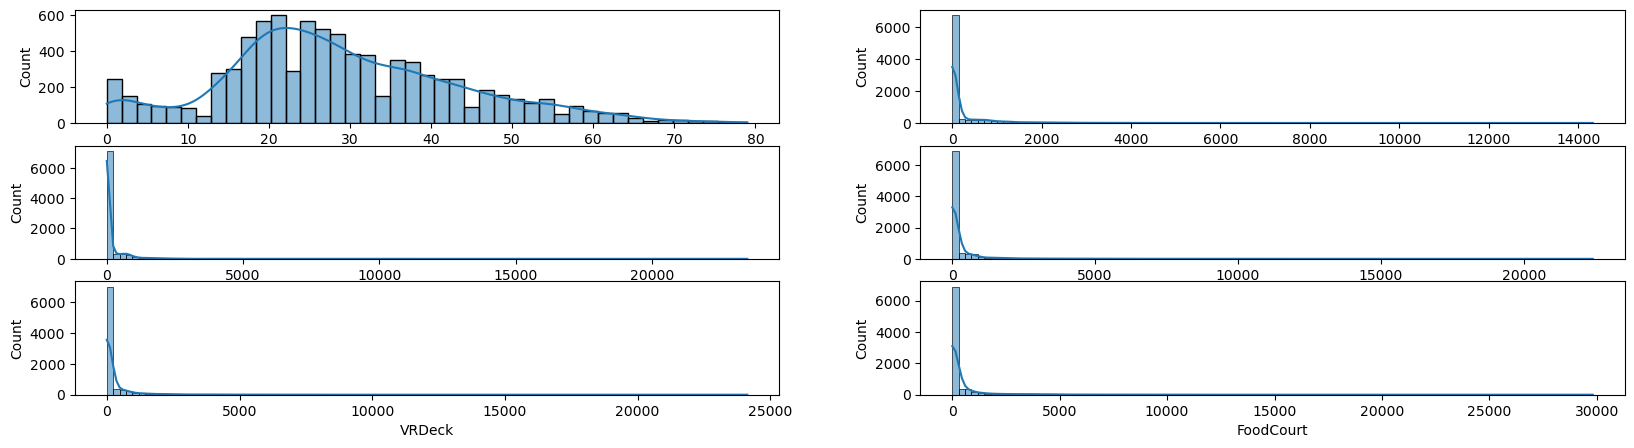

In [10]:
fig, ax = plt.subplots(3,2, figsize=(20, 5))
sns.histplot(train['Age'], kde=True, ax = ax[0][0])
sns.histplot(train['RoomService'], kde=True,bins=100, ax = ax[0][1])
sns.histplot(train['ShoppingMall'], kde=True,bins=100, ax = ax[1][0])
sns.histplot(train['Spa'], kde=True,bins=100, ax = ax[1][1])
sns.histplot(train['VRDeck'], kde=True,bins=100, ax = ax[2][0])
sns.histplot(train['FoodCourt'], kde=True,bins=100, ax = ax[2][1])



<Axes: xlabel='HomePlanet', ylabel='Spa'>

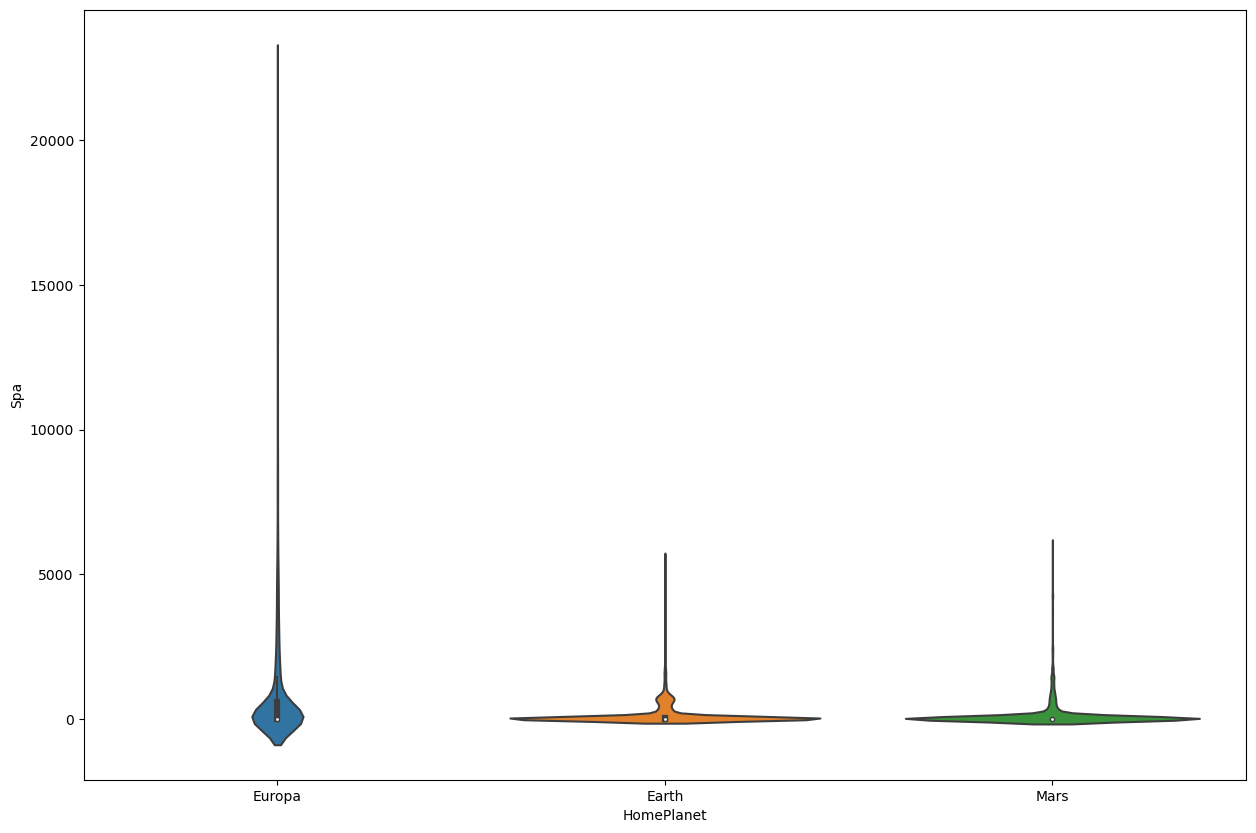

In [11]:
plt.figure(figsize=(15, 10))
sns.violinplot(data=train, x='HomePlanet', y='Spa')

<Axes: >

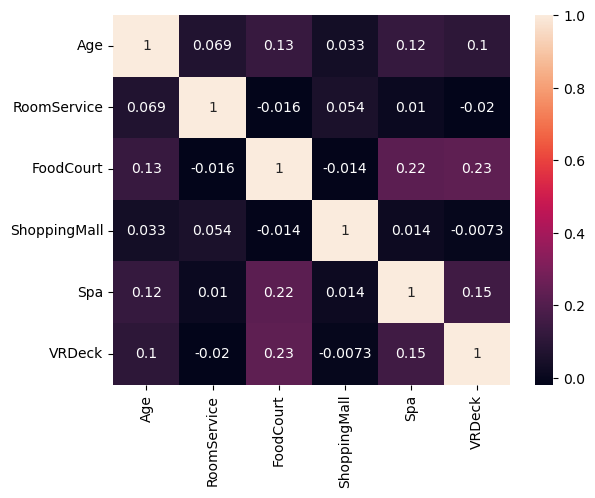

In [12]:
train_numeric = train.select_dtypes(include='float64')
sns.heatmap(train_numeric.corr(), annot=True)

<Axes: >

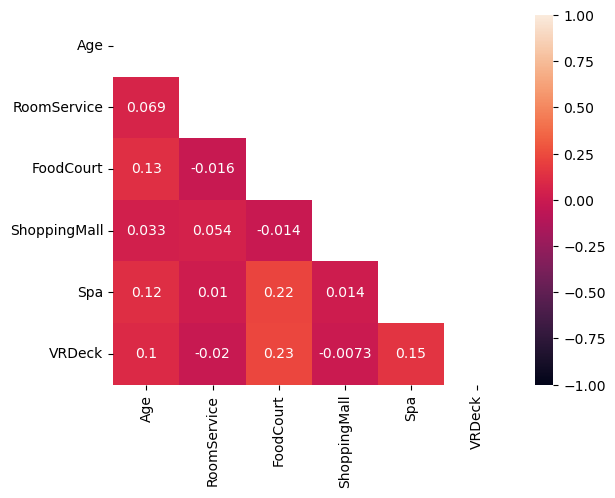

In [13]:
mask = np.triu(np.ones_like(train_numeric.corr()))
sns.heatmap(train_numeric.corr(), annot=True, mask = mask, vmin=-1, vmax=1)


In [14]:
X = train.drop(['Transported', 'PassengerId', 'Name', 'Cabin'], axis = 1)
X_encoded = pd.get_dummies(X)
X_encoded

X_test = test.drop(['PassengerId', 'Name', 'Cabin'], axis = 1)
X_test_encoded = pd.get_dummies(X_test)
X_test_encoded

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,27.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,1,0,0,1,0,0,0,1,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,0,1,0,1,0,0,0,1,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0
4273,42.0,0.0,847.0,17.0,10.0,144.0,1,0,0,1,0,0,0,1,1,0
4274,NaN,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,0,0,1,0
4275,NaN,0.0,2680.0,0.0,0.0,523.0,0,1,0,1,0,0,0,0,1,0


In [15]:
X_encoded


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,1,0,0,0,1,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,1,0,0,0,1,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,1,0,0,0,1,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,0,1,0,1,0,0,0,1
8689,18.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,1,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1,0,0,1,0,0,0,1,1,0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0,1,0,1,0,1,0,0,1,0


In [16]:
lb = LabelEncoder()
y = lb.fit_transform(train['Transported'])

In [17]:
model = RandomForestClassifier()
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 23)
imputer = SimpleImputer()
pipe = Pipeline([('Imputer', imputer), ('reg', model)])
params = { 'reg__max_depth': [None, 2, 3], 
              'reg__min_samples_leaf' : [1, 2, 3],
              'reg__min_samples_split': [2, 3, 4],
              'reg__n_estimators' : [50, 100, 150]
}
gcv = RandomizedSearchCV(pipe, param_distributions=params, cv = kfold, verbose = 3, scoring = 'neg_log_loss')
gcv.fit(X_encoded, y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END reg__max_depth=3, reg__min_samples_leaf=3, reg__min_samples_split=2, reg__n_estimators=150;, score=-0.504 total time=   0.7s
[CV 2/5] END reg__max_depth=3, reg__min_samples_leaf=3, reg__min_samples_split=2, reg__n_estimators=150;, score=-0.521 total time=   0.8s
[CV 3/5] END reg__max_depth=3, reg__min_samples_leaf=3, reg__min_samples_split=2, reg__n_estimators=150;, score=-0.516 total time=   0.7s
[CV 4/5] END reg__max_depth=3, reg__min_samples_leaf=3, reg__min_samples_split=2, reg__n_estimators=150;, score=-0.515 total time=   0.7s
[CV 5/5] END reg__max_depth=3, reg__min_samples_leaf=3, reg__min_samples_split=2, reg__n_estimators=150;, score=-0.526 total time=   0.7s
[CV 1/5] END reg__max_depth=3, reg__min_samples_leaf=1, reg__min_samples_split=4, reg__n_estimators=50;, score=-0.507 total time=   0.3s
[CV 2/5] END reg__max_depth=3, reg__min_samples_leaf=1, reg__min_samples_split=4, reg__n_estimators=50;, score=-

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('Imputer', SimpleImputer()),
                                             ('reg',
                                              RandomForestClassifier())]),
                   param_distributions={'reg__max_depth': [None, 2, 3],
                                        'reg__min_samples_leaf': [1, 2, 3],
                                        'reg__min_samples_split': [2, 3, 4],
                                        'reg__n_estimators': [50, 100, 150]},
                   scoring='neg_log_loss', verbose=3)

In [19]:
print(gcv.best_params_)
print(gcv.best_score_)

{'reg__n_estimators': 50, 'reg__min_samples_split': 2, 'reg__min_samples_leaf': 3, 'reg__max_depth': None}
-0.44475886368503625


In [20]:
submissions = gcv.predict(X_test_encoded)
sub = np.array(submissions, dtype=bool)

In [21]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Transported': sub})
output.to_csv('submission.csv', index=False)
print('saved')

saved
